# Class 11: Clustering & Community Detection 2 — Contemporary

Goal of today's class:
1. Isolate issues with modularity
2. Introduce a statistical framework for community detection
3. Graph!Tool! 

*Acknowledgement: This lesson was made in collaboration with Erik Weis, a PhD student in Network Science at Northeastern University.*
__________

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Open up the Jupyter Lab terminal.
5. Activate Conda: `module load anaconda3/2022.05`
6. Activate the shared virtual environment: `source activate /courses/PHYS7332.202510/shared/phys7332-env/`
7. Run `python3 git_fixer2.py`
8. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main
________

In [13]:
# !pip install networkx
# !pip install python-louvain
# !pip install pandas
# !pip install community

In [1]:
import sys
print(sys.path)

['/courses/PHYS7332.202510/shared/graphtool/lib/python312.zip', '/courses/PHYS7332.202510/shared/graphtool/lib/python3.12', '/courses/PHYS7332.202510/shared/graphtool/lib/python3.12/lib-dynload', '', '/courses/PHYS7332.202510/shared/graphtool/lib/python3.12/site-packages']


In [3]:
import networkx as nx
import numpy as np
# import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

## Trouble in Modularity Paradise...

Let's start with two exercises to motivate today's lesson, both of which point to a deep concern in the utility of *modularity* as a graph property and as a measure to optimize over when identifying communities in networks.

Recall that the modularity, $Q$, of a given partition $C$ of our adjacency matrix $A$ is:

$$Q (A,C) = \frac{1}{2M} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2M} \right) \delta (C_i,C_j) $$

The key idea behind this measure was that to calculate the number of within-community edges that exist above and beyond what we'd expect just based on nodes' degrees. What follows is the assumption (or, rather, the hope) that we should not find community structure in Erdős–Rényi random graphs. Let's explore this with two exercises where we run a modularity-maximizing community detection algorithm over hundreds of ER graphs.

Using a graph of size $N=200$, loop over various values for $p$ to create many ER graphs. Compute the `community.best_partition` of each of these, and store the following:

1. The modularity of the `best_partition` for each randomly generated graph.
2. The number of communities detected in each partition.

In [4]:
import community
plist = np.logspace(-3.5,0,501)
N = 200
modularity_out = []
num_commun_out = []

for p in plist:
    G_i = nx.erdos_renyi_graph(N,p)
    part_i = community.best_partition(G_i)
    num_commun_out.append(len(set(part_i.values())))
    modularity_out.append(community.modularity(part_i, G_i))

AttributeError: 'list' object has no attribute 'rolling'

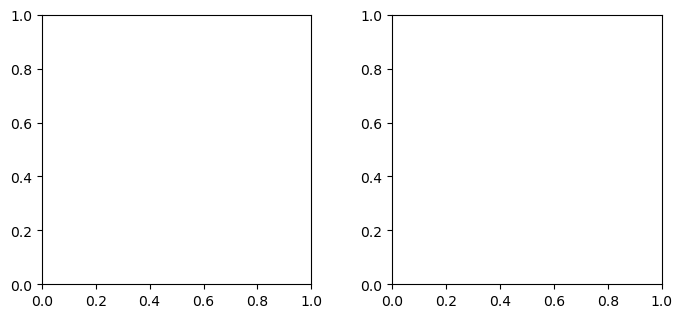

In [6]:
fig, ax = plt.subplots(1,2,figsize=(8,3.5),dpi=100)
plt.subplots_adjust(wspace=0.3)

ax[0].semilogx(plist, pd.Series(num_commun_out).rolling(window=10).mean(), color='.2', lw=2)
ax[1].semilogx(plist, pd.Series(modularity_out).rolling(window=10).mean(), color='.2', lw=2)

ax[0].set_ylabel('Number of communities detected\n(network size = 200)')
ax[0].set_xlabel(r'$p$')
ax[0].set_ylim(0,N)

ax[1].vlines(1/(N-1),0,1,ls='--',color='orange',label=r'$\langle k \rangle = 1$')
ax[1].vlines(np.log(N)/(N-1),0,1,ls=':',color='firebrick',label=r'$\langle k \rangle = \log N$')
ax[1].legend(fontsize='small')
ax[1].set_ylabel('Modularity')
ax[1].set_xlabel(r'$p$')
ax[1].set_ylim(0,1)
ax[0].grid(alpha=0.25, lw=1, color='.75')
ax[1].grid(alpha=0.25, lw=1, color='.75')

plt.show()

What does this mean?

What does this mean for real networks? Let's find out.
________
For reference, let's load the PolBlogs datasets from class 2 and 3:

In [7]:
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

digraph = nx.DiGraph()
with open('data/polblogs_nodes_class.tsv','r') as fp:
    for line in fp:
        node_id, node_label, node_political = line.strip().split('\t')
        political_orientation = 'liberal' if node_political == '0' else 'conservative'
        digraph.add_node(node_id, website=node_label, political_orientation=political_orientation)
        
with open('data/polblogs_edges_class.tsv','r') as fp:
    for line in fp:
        source_node_id, target_node_id = line.strip().split('\t')
        digraph.add_edge(source_node_id, target_node_id)

# just select the largest strongly connected component, and 
sccs = sorted(nx.strongly_connected_components(digraph), key=len, reverse=True)
G = nx.to_undirected(digraph.subgraph(sccs[0]))

# get the political leanings and assign them to colors
cols = ["#c5c03a","#7275d7","#8fb755","#c361bd","#5ec384","#d3537a","#3fe0d8","#cb6b3b"]
leanings = nx.get_node_attributes(G,'political_orientation')
node_colors = [cols[0] if leaning=='conservative' else cols[1] \
               for leaning in leanings.values()]

edge_colors = '.4'
pos = nx.spring_layout(G)

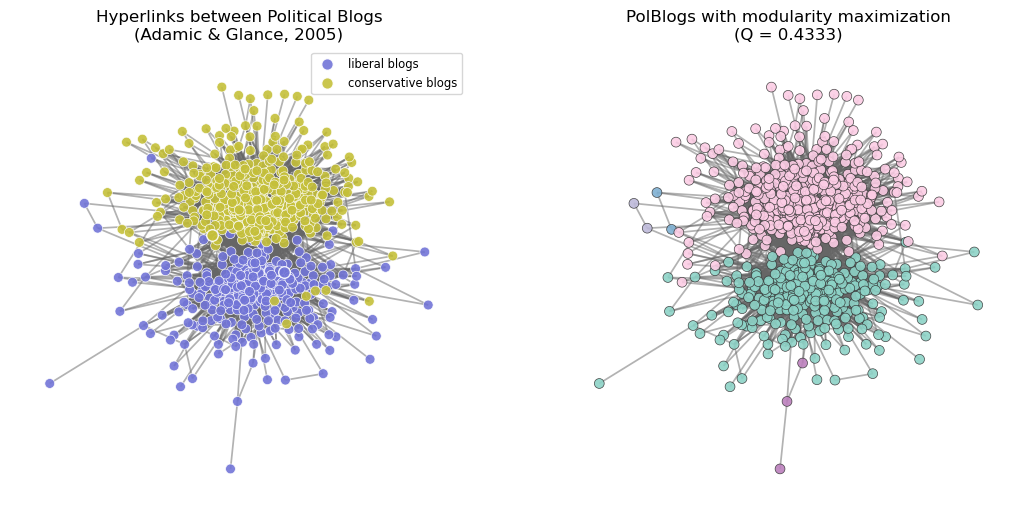

In [8]:
fig, ax = plt.subplots(1,2,figsize=(13,6),dpi=100)

nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                       node_size=50, edgecolors='w', alpha=0.9, linewidths=0.5, ax=ax[0])
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.25, alpha=0.5, ax=ax[0])
ax[0].set_title('Hyperlinks between Political Blogs\n(Adamic & Glance, 2005)', fontsize='large')
ax[0].set_axis_off()

legend_node0 = '0'
legend_node1 = '1000'
nx.draw_networkx_nodes(G, {legend_node0:pos[legend_node0]}, nodelist=[legend_node0], 
                       label='liberal blogs', 
                       node_color=cols[1], node_size=70, edgecolors='w', alpha=0.9, ax=ax[0])
nx.draw_networkx_nodes(G, {legend_node1:pos[legend_node1]}, nodelist=[legend_node1], 
                       label='conservative blogs',
                       node_color=cols[0], node_size=70, edgecolors='w', alpha=0.9, ax=ax[0])
ax[0].legend(fontsize='small')


part = community.best_partition(G)
ncs = plt.cm.Set3([i/len(set(part.values())) for i in part.values()])

nx.draw_networkx_nodes(G, pos, node_color=ncs,
                       node_size=50, edgecolors='.2', alpha=0.9, linewidths=0.5, ax=ax[1])
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.25, alpha=0.5, ax=ax[1])

ax[1].set_title('PolBlogs with modularity maximization\n(Q = %.4f)'%community.modularity(part,G),
                fontsize='large')
ax[1].set_axis_off()


plt.show()

Where does the PolBlogs modularity fall in our plot from above?

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3.5),dpi=100)
plt.subplots_adjust(wspace=0.3)

ax[0].semilogx(plist, pd.Series(num_commun_out).rolling(window=10).mean(), color='.2', lw=2)
ax[0].semilogx([nx.density(G)], [len(set(part.values()))], '*',
               markersize=14, color='limegreen', label='PolBlogs', markeredgewidth=0)
ax[1].semilogx(plist, pd.Series(modularity_out).rolling(window=10).mean(), color='.2', lw=2)

ax[0].set_ylabel('Number of communities detected\n(network size = 200)')
ax[0].set_xlabel(r'$p$')
ax[0].set_ylim(0,N)
ax[0].legend(fontsize='small')

ax[1].vlines(1/(N-1),0,1,ls='--',color='orange',label=r'$\langle k \rangle = 1$')
ax[1].vlines(np.log(N)/(N-1),0,1,ls=':',color='firebrick',label=r'$\langle k \rangle = \log N$')
ax[1].semilogx([nx.density(G)],[community.modularity(part,G)], '*', 
               markersize=14, color='limegreen', label='PolBlogs', markeredgewidth=0)
ax[1].legend(fontsize='small')
ax[1].set_ylabel('Modularity')
ax[1].set_xlabel(r'$p$')
ax[1].set_ylim(0,1)


plt.show()

__________

This result is quite remarkable! And known for quite some time! Indeed in 2003, Roger Guimerà, Marta Sales-Pardo, and Luís Amaral published an article exploring this exact issue with the modularity measure.

- Guimera, R., Sales-Pardo, M., & Amaral, L.A.N. (2004). [Modularity from fluctuations in random graphs and complex networks](https://link.aps.org/doi/10.1103/PhysRevE.70.025101). *Physical Review E*, 70(2), 025101.

From the conclusion of their article: "...modularity in networks can arise due to a number of mechanisms. We have demonstrated that networks embedded in low-dimensional spaces have high modularity. We have also shown analytically and numerically that, surprisingly, **random graphs and scale-free networks have high modularity due to fluctuations in the establishment of links**."

They continue, arguing that many of the papers emerging in the early 2000s, which make theoretical claims about some real-world system based on measures of modularity (e.g. biological systems must have evolved to become modular) are potentially incomplete. These claims are based on network data that yields a partition with high ("high") modularity. Crucially, the authors note, this "**relies implicitly on the assumption that random graphs have low modularity.**"

![](images/modularity_from_fluctuations.png)

The authors conclude by arguing that their result paves the way for a notion of statistical significance for modularity (similar to what had been created for clustering coefficients, etc.). However, today, we revisit this paper for a different reason: to emphasize that the problems with modularity maximization don't just stop there (though these findings are particularly damning for a measure purporting to offer a useful and interpretable notion of how strong the community structure is in a graph).

_________

## Enter: `graph-tool`

Note: The remainder of this lesson will draw heavily from the [`graph-tool` documentation](https://graph-tool.skewed.de/) directly. This package is written and maintained almost entirely by [Tiago Peixoto](https://skewed.de/lab/contact.html), professor of Complex Systems and Network Science at IT:U in Linz, Austria.


https://graph-tool.skewed.de/static/doc/quickstart.html

**Punchline:** Use this package to detect communities in your network data. 

In [9]:
from graph_tool.all import *

In [10]:
g = collection.ns["ego_social/facebook_combined"]

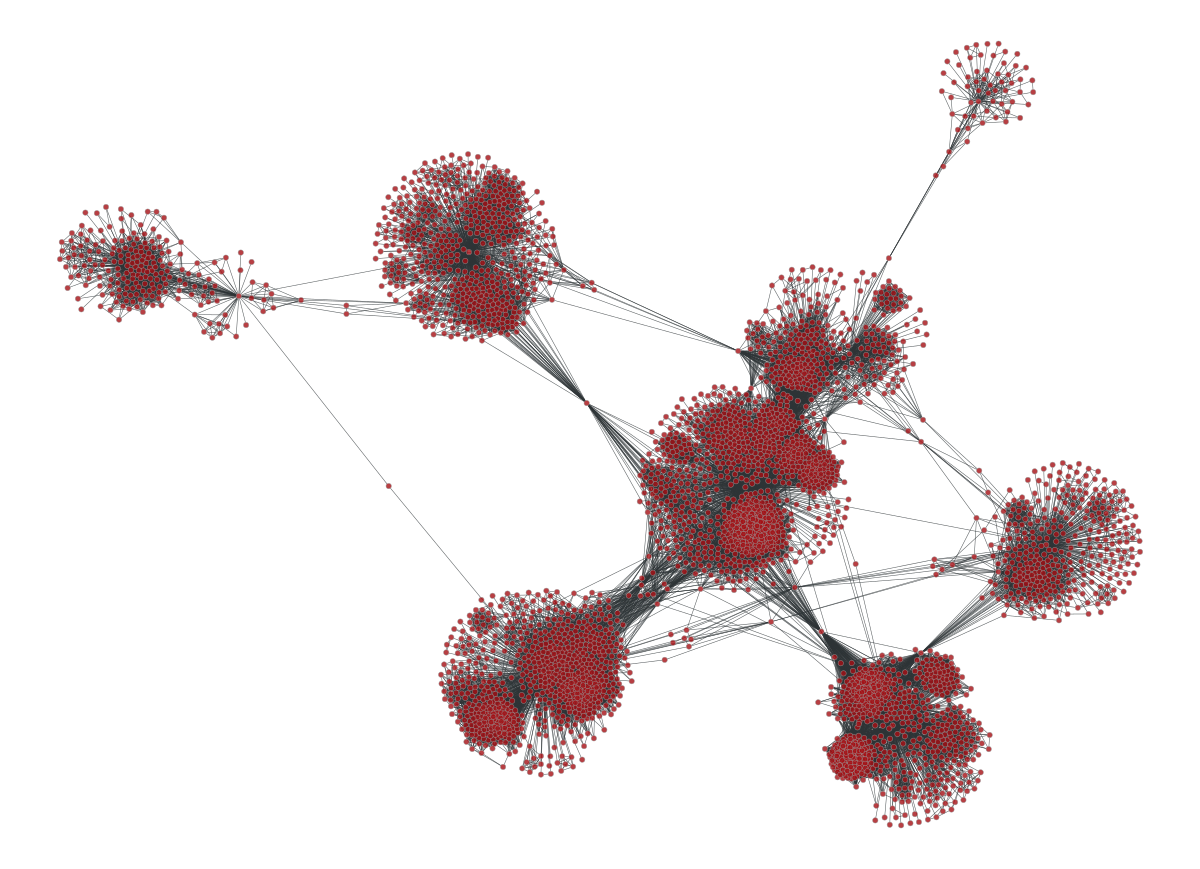

In [11]:
graph_draw(g, g.vp._pos);
#graph_draw(g, g.vp._pos, output="facebook.pdf")

In [12]:
state = minimize_blockmodel_dl(g)

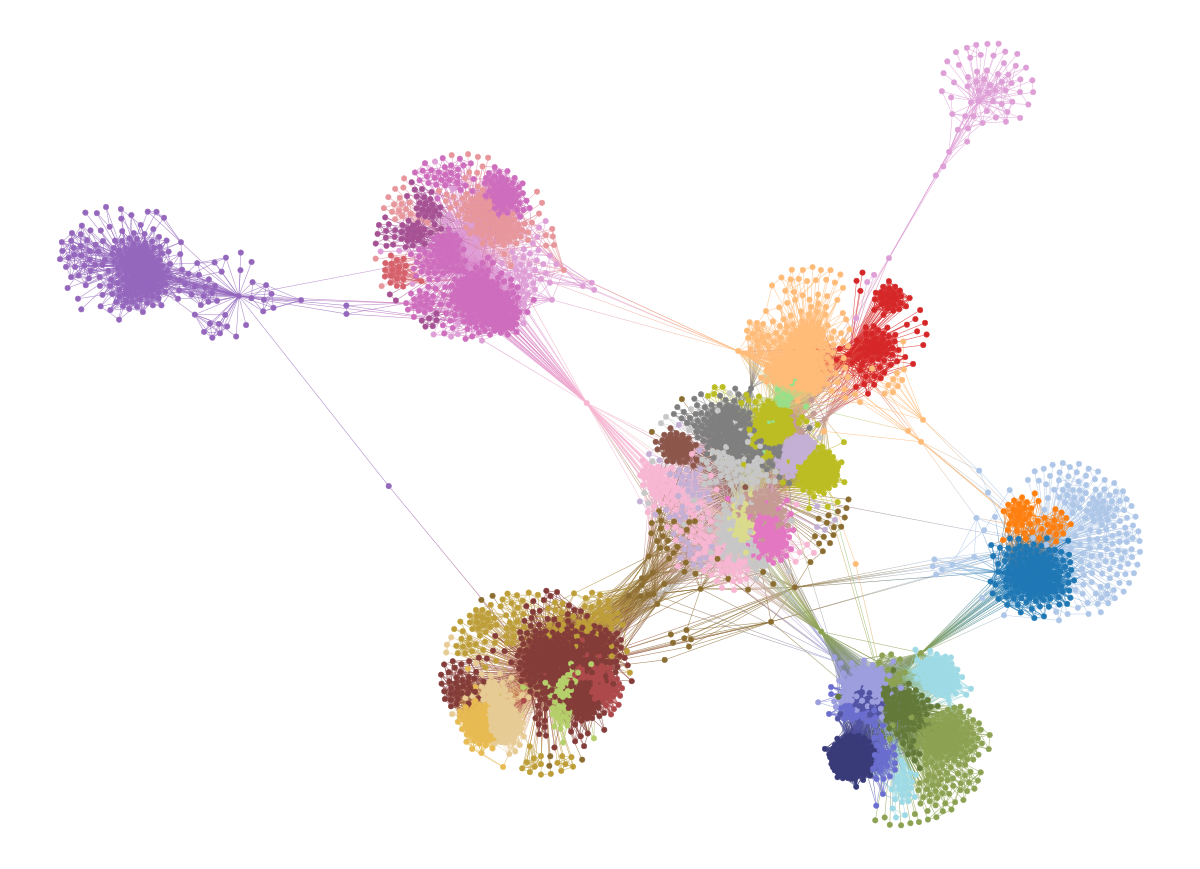

In [13]:
state.draw(pos=g.vp._pos);
# state.draw(pos=g.vp._pos, output="facebook-sbm.pdf")

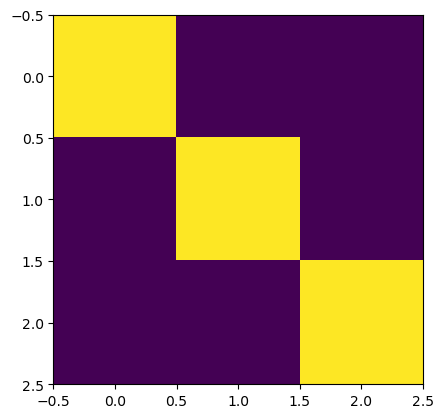

In [14]:
plt.imshow(np.array([[0.9, 0.05, 0.05], 
                     [0.05, 0.9, 0.05], 
                     [0.05, 0.05, 0.9]]))

In [15]:
# five lines of code will get you community detection


In [16]:
# start with modularity exercise --- done
    # how many communities
    # how many communities should be in ER?

# show it's bad
# intro bayes, why it's good

# say there's objective function, intro Desc Leng 
# show the minimize blockmodel dl (or nested)
### what's the diff with nested?

# 5 lines of community detection code
### minimize blockmodel
### refine https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#refinements-using-merge-split-mcmc

### discuss degree correction -- it's a model selection choice,

# basic package operations etc.
# spend time on viz
# show some netschleuder integration

###### close with the comfort that if you're gonna do community detection then you shuold use gt


### Caution notes:
##### Assortative vs dis/other-assortative communities
##### Assumes multigraphs
##### Weighted vs multigraphs
##### clarify that this should be interpreted as "structural similarity" if i and j are in the same block, a la 1970s social science


# If there's time:
### show example of topic model?
### if there's time, recon?

__________
## Next time...
Visualization 1 — Python + Gephi! `class_12_visualization1.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://asmithh.github.io/network-science-data-book/intro.html
    - Github: https://github.com/asmithh/network-science-data-book
    - Syllabus and course details: https://brennanklein.com/phys7332-fall24
2. `graph-tool` documentation: https://graph-tool.skewed.de/
3. Guimera, R., Sales-Pardo, M., & Amaral, L.A.N. (2004). [Modularity from fluctuations in random graphs and complex networks](https://link.aps.org/doi/10.1103/PhysRevE.70.025101). *Physical Review E*, 70(2), 025101.
4. Tiago Peixoto's blog: https://skewed.de/lab/blog.html
5. Statistical Inference Satellite at the NetSci conference https://sinm.network/